Now we have seen how to build a model, let's use these concepts to build a predictive model on our data.

Specifically, we are going to try to predict the return of SOL in the next hour with a simple model that uses hourly volatility and close returns

In [1]:
data_location = 'sqlite:///../../../data/data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [5]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

## Data formatting

First, let's format the data.  right now the data set is long, i.e. each row is unique on ts/token, however we want to make each row unique on ts only.  We are converting a long table into a fat table of features

In [6]:
tokens = ohlc.token.unique()

In [7]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [8]:
X.shape

(1057, 22)

In [9]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

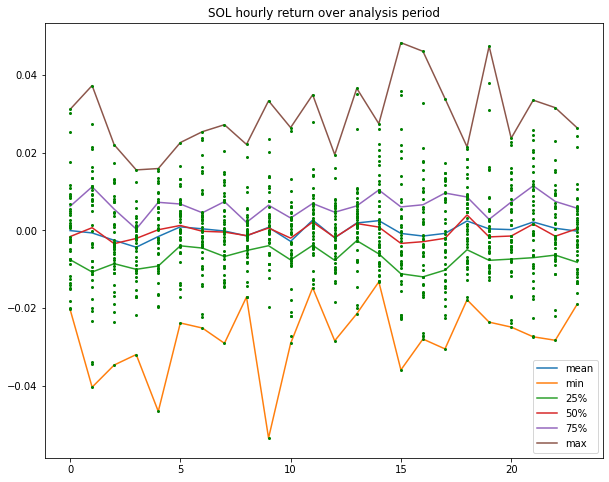

In [10]:
plt.rcParams['figure.figsize'] = [10,8]
temp_x = np.split(X.ret_SOL, 1056/24)
pd.DataFrame(np.stack(temp_x)).describe().T[['mean','min','25%','50%','75%','max']].plot()
for i in range(len(temp_x)):
    plt.plot(np.arange(0,24), temp_x[i],'o',color='green', markersize=2)
plt.title('SOL hourly return over analysis period')
plt.show()

In [11]:
lags = 5
new_X = pd.DataFrame()
temp_X = X.loc[:,['ret_SOL','vol_SOL']]
for i in range(lags):
    if i > 0:
        X_lag = temp_X.shift(i*24-1)
    else:
        X_lag = temp_X.shift(i*24)
    X_lag.columns = [col + '_l'+str(i) for col in temp_X.columns]
    new_X = pd.concat([new_X, X_lag], axis=1)

In [12]:
new_X['ret_other'] = pd.concat([X[col] for col in X.columns if ('SOL' not in col and 'vol' not in col)], axis=1).mean(axis=1)
new_X['vol_other'] = pd.concat([X[col] for col in X.columns if ('SOL' not in col and 'ret' not in col)], axis=1).mean(axis=1)

In [13]:
new_X.shape

(1056, 12)

In [14]:
y.shape

(1056,)

Let's analyze our data a little bit

In [15]:
y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

In [16]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

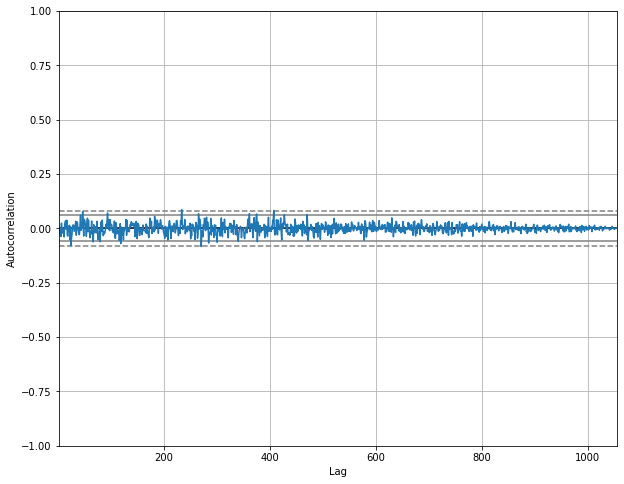

In [17]:
autocorrelation_plot(y[1:])

we can see that the hourly returns for aave doesn't have any strong autocorrelation

In [18]:
corr_dic = {col: [y.corr(new_X[col])] for col in new_X.columns if new_X[col].dtype != 'object'}
pd.DataFrame(corr_dic).T.sort_values([0],ascending=False)

,0
ret_SOL_l4,0.040053
vol_other,0.036281
vol_SOL_l0,0.034853
ret_other,0.018551
vol_SOL_l4,0.015992
vol_SOL_l3,0.011376
ret_SOL_l3,-0.019662
vol_SOL_l2,-0.022243
ret_SOL_l0,-0.029855
ret_SOL_l2,-0.034179


finally, we can take a quick look at the correlation between y and our X variables.  We see here that the correlations are pretty weak on a column by column basis

Next, let's set up a set of transformers so that we can augment our data before it hits the model

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [20]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])


In [21]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', Ridge(alpha = 1.0))
])

evaluate_model(pipeline, new_X, y)

-0.008511279487891961

In [22]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=11)),
    ('model', Ridge(alpha = 1.0))
])

evaluate_model(pipeline, new_X, y)

-0.008502009998034226

In [23]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', Ridge(alpha = 1.0))
])

evaluate_model(pipeline, new_X[['ret_SOL_l0','ret_SOL_l1','ret_other']], y)

-0.008472871905883441

In [24]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, new_X, y)

-0.008839407747529001

The above looks pretty good, however let's optimize the alpha parameter on the Ridge

In [25]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    #('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    #'pca__n_components': [1, 5, 10, 11],
    'model__alpha': [0.1, 0.25, 0.5, 0.75, 1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(new_X[['ret_SOL_l0','ret_SOL_l1','ret_other']], y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.25, 0.5, 0.75, 1.0]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [26]:
search.best_params_

{'model__alpha': 0.1}

In [27]:
best_model = search.best_estimator_

In [28]:
evaluate_model(best_model, new_X[['ret_SOL_l0','ret_SOL_l1','ret_other']], y)

-0.008472757231226324

Let's check the learning curve of our best model

<module 'matplotlib.pyplot' from '/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

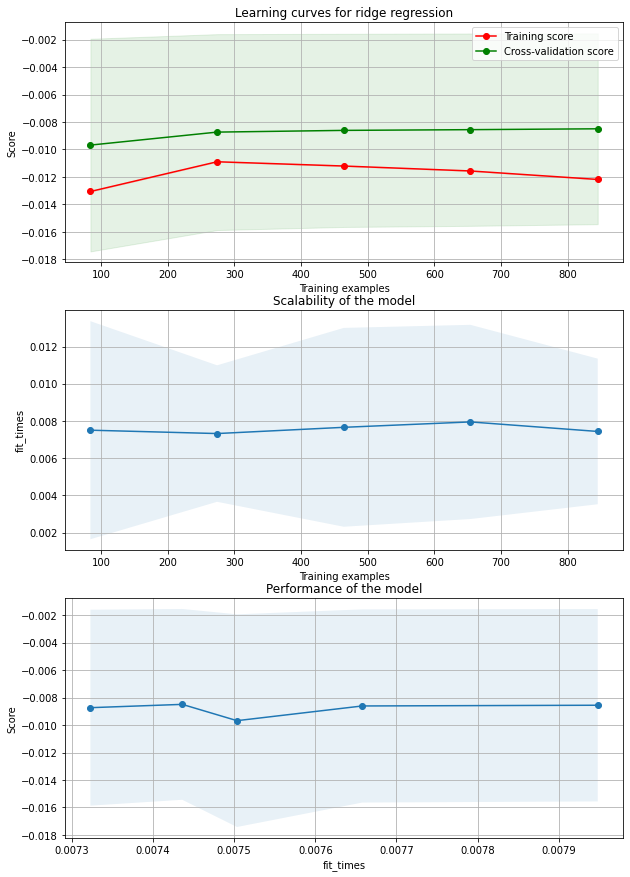

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, new_X[['ret_SOL_l0','ret_SOL_l1','ret_other']], y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


Now that we have completed the model, we will need to save it down so that we can load it up in our model.  To do this, we will use pickle

In [30]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))

We can verify that this is the same model that we saved:

In [31]:
loaded_model = pickle.load(open('best_model.pkl', 'rb'))

In [32]:
loaded_model.predict(new_X[['ret_SOL_l0','ret_SOL_l1','ret_other']].iloc[[-1]])

array([0.00189435])

In [33]:
best_model.predict(new_X[['ret_SOL_l0','ret_SOL_l1','ret_other']].iloc[[-1]])

array([0.00189435])

In [34]:
best_model

Pipeline(steps=[('impute', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scale', StandardScaler()), ('model', Ridge(alpha=0.1))])

In [35]:
loaded_model

Pipeline(steps=[('impute', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scale', StandardScaler()), ('model', Ridge(alpha=0.1))])